# Домашнее задание 5

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1 (10 pts)

Пусть задан набор из $N$ пар точек в $n$-мерном пространстве $x_1, \ldots , x_N$ и $y_1, \ldots, y_N$.
Также даны расстояния $d_1, \ldots , d_N$ между ними. Необходимо найти такую матрицу $M \in \mathbb{S}^n_+$, что 
$d_i \approx d(x_i, y_i) = \sqrt{(x_i − y_i)^TM(x_i − y_i)}$. 
Таким образом, целевой функцией в
данной задаче является следующая функция
$$ 
\min_{M \in \mathbb{S}^n_+} \frac{1}{N}\sum_{i=1}^N (d_i - d(x_i, y_i))^2.
$$

В данном случае при старте из точки $M_0 \in \mathbb{S}^n_+$ тестируемые методы не должен выводить промежуточные точки $M_k$ за границы допустимого множества, но не забудьте это проверять и модифицируйте размер шага соответственно.

Сравните сходимость градиентного спуска, метода тяжёлого шарика и быстрого градиентного метода для решения этой задачи.

Также проверьте ошибку на тестовых данных ```d_test, X_test, Y_test```. Прокомментируйте результат.

\begin{align*}
    f(M)_{M \in \mathbb{S}^n_+} 
        &= f(A A^T)_{A \in \mathbb{R}^{n \times n}} = g(A) \\
        &= \frac{1}{N}\sum_{i=1}^N (d_i - d(x_i, y_i))^2 \\
        &= \frac{1}{N}\sum_{i=1}^N \left(d_i - \sqrt{(x_i - y_i)^T A A^T (x_i - y_i)} \right)^2 \\
        &= \frac{1}{N}\sum_{i=1}^N d_i^2 - 2 d_i \sqrt{(x_i - y_i)^T A A^T (x_i - y_i)} + (x_i - y_i) A A^T (x_i - y_i)
\end{align*}

Обозначим за $[\varepsilon_{i, j}]$ матрицу состоющую из 0, где на месте $i, j$ стоит $\varepsilon$.  
Аналогично $[A_{i, j}]$ матрица состоящая из 0, где на месте $i, j$ стоит $i, j$-ый элемент матрицы $A$.  
Рассмотрим выражение
\begin{align*}
    h(A + [\varepsilon_{i, j}]) - h(A) 
        &= x^T \left( A + [\varepsilon_{i, j}] \right) \left( A + [\varepsilon_{i, j}] \right)^T x - x^T A A^T x \\
        &= x^T \left( A + [\varepsilon_{i, j}] \right) \left( A^T + [\varepsilon_{j, i}] \right) x - x^T A A^T x \\
        &= x^T \left( A A^T + [\varepsilon_{i, j}] A^T + A [\varepsilon_{j, i}] + [\varepsilon_{i, j}] [\varepsilon_{j, i}] \right) x - x^T A A^T x \\
        &= x^T \left( [\varepsilon_{i, :} A_{:, j}] + [\varepsilon_{:, i} A_{:, j}] \right) x + \theta(\varepsilon^2 ) \quad 
            \textit{Где }[\varepsilon_{i, :} A_{:, j}] \textit{ матрица состоящая из i-ой строки заполненной } \varepsilon A_{:, j} \\
        &= 2 x^T [\varepsilon_{i, :} A_{:, j}] x + \theta(\varepsilon^2) \\
        &= \varepsilon 2 x[i] A_{:, j} x + \theta(\varepsilon^2)
\end{align*}

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm.notebook import tqdm
from scipy import linalg as la


In [2]:
# На всякий случай проверим
x = np.random.randint(1, 10, size=6)
A = np.random.randint(1, 10, size=(6, 6))
eps = 2
i, j = 3, 5

EPS = np.zeros_like(A)
EPS[i, j] = eps

print(x.T @ (A + EPS) @ (A + EPS).T @ x - x.T @ A @ A.T @ x == 2 * eps * x[i] * A[:, j] @ x + x.T @ EPS @ EPS.T @ x)
# print(x.T @ (A + EPS) @ (A.T + EPS.T) @ x - x.T @ A @ A.T @ x)
# print(x.T @ (A @ A.T + EPS @ A.T + A @ EPS.T + EPS @ EPS.T) @ x - x.T @ A @ A.T @ x)
# print(x.T @ (EPS @ A.T + A @ EPS.T + EPS @ EPS.T) @ x )
# print(x.T @ (EPS @ A.T + A @ EPS.T) @ x + x.T @ EPS @ EPS.T @ x)
# print(x.T @ EPS @ A.T @ x * 2 + x.T @ EPS @ EPS.T @ x)
# print(x.T @ EPS @ A.T @ x * 2 + x.T @ EPS @ EPS.T @ x)
# print(2 * eps * x[i] * A[:, j] @ x + x.T @ EPS @ EPS.T @ x)

True


Посчитаем градиент относительно $i, j$ элемента функции $g$ 
\begin{align*}
    g'_{i, j} (A) 
        &= \frac{1}{N} \sum_{k=1}^N 
            2(x_{i, k} - y_k)[i] A_{:, j} (x_{i, k} - y_k) - 
            2 d_k \frac{1}{2\sqrt{(x_{i, k} - y_k)^T A A^T (x_{i, k} - y_k)}} 2(x_{i, k} - y_k)[i] A_{:, j} (x_{i, k} - y_k) \\
        &= \frac{1}{N} \sum_{k=1}^N 2(x_{ik} - y_{ik}) A_{:, j} (x_{i, k} - y_k) \left( 1 - \frac{d_k}{\sqrt{(x_{i, k} - y_k)^T A A^T (x_{i, k} - y_k)}} \right)
\end{align*}

In [36]:
@njit
def grad(X, Y, d, A):
    # Наверняка можно представить градиент в виде хитрого матричного выражения
    # Но быстро это сделать у меня не вышло
    
    N = len(X[0])
    ans = np.zeros_like(A)
    for i in range(len(A)):
        for j in range(len(A)):
            for k in range(N):
                ans[i, j] += 2 * (X[i, k] - Y[i, k]) * A[:, j] @ (X[:, k] - Y[:, k]) * \
                    (1 - d[k] / np.sqrt((X[:, k] - Y[:, k]).T @ A @ A.T @ (X[:, k] - Y[:, k]))) / N

    return ans

def gradient_descent(grad, alpha, A0, num_iter, tol):
    A = A0.copy()
    conv = [A0.copy()]
    for _ in tqdm(range(num_iter)):
        g = grad(A)
        if np.linalg.norm(g) < tol:
            break

        A = A - alpha * g
        conv.append(A.copy())
    return A, conv

In [37]:
def heavy_ball(grad, alpha, beta, A0, num_iter, tol):
  conv = [A0.copy()]
  A = A0.copy()
  for k in tqdm(range(num_iter)):
    g = grad(A)
    if np.linalg.norm(g) < tol:
      break
    if k == 0:
      A = A - alpha * g
    else:
      A = A - alpha * g + beta * (A - conv[-2])

    conv.append(A.copy())

  return A, conv

def fast_gradient_descent(grad, alpha, A0, num_iter, tol):
  conv = [A0.copy()]
  A = A0.copy()
  v = A0.copy()
  theta = 1.
  for k in tqdm(range(num_iter)):
    y = (1 - theta) * A + theta * v
    g = grad(y)
    A = y - alpha * g
    v = conv[-1] + 1 / theta * (A - conv[-1])
    conv.append(A.copy())
    theta = 2 / (k+2)
    
  return A, conv

In [ ]:

def target_func(X, Y, d, A):
    ans = 0
    N = len(X[0])
    for i in range(N):
        ans += (d[i] - np.sqrt((X[:, i] - Y[:, i]).T @ A @ A.T @ (X[:, i] - Y[:, i]))) ** 2

    return ans / N

In [20]:
np.random.seed(8)

n = 5 # Dimension
N = 100 # Number of sample
N_test = 10 # Samples for test set

X = np.random.randn(n,N)
Y = np.random.randn(n,N)

X_test = np.random.randn(n,N_test)
Y_test = np.random.randn(n,N_test)

P = np.random.randn(n,n)
P = P.dot(P.T) + np.identity(n)
sqrtP = la.sqrtm(P)

d = np.linalg.norm(sqrtP.dot(X-Y),axis=0)
d = np.maximum(d+np.random.randn(N),0)
d_test = np.linalg.norm(sqrtP.dot(X_test-Y_test),axis=0)
d_test = np.maximum(d_test+np.random.randn(N_test),0)

In [26]:
A, conv_gd = gradient_descent(lambda A: grad(X, Y, d, A), 1e-2, np.eye(n), 10_000, 1e-5)
A, conv_hb = heavy_ball(lambda A: grad(X, Y, d, A), 1e-2, 0.9, np.eye(n), 10_000, 1e-5)
A, conv_fgd = fast_gradient_descent(lambda A: grad(X, Y, d, A), 1e-2, np.eye(n), 10_000, 1e-5)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

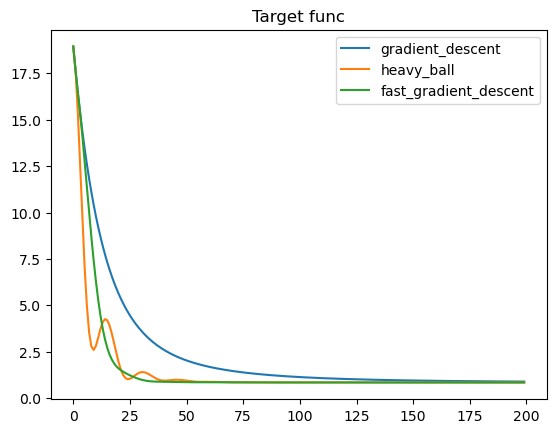

In [35]:
plt.title('Target func')
plt.plot([target_func(X, Y, d, A) for A in conv_gd[:200]], label='gradient_descent')
plt.plot([target_func(X, Y, d, A) for A in conv_hb[:200]], label='heavy_ball')
plt.plot([target_func(X, Y, d, A) for A in conv_fgd[:200]], label='fast_gradient_descent')
plt.legend()
plt.show()

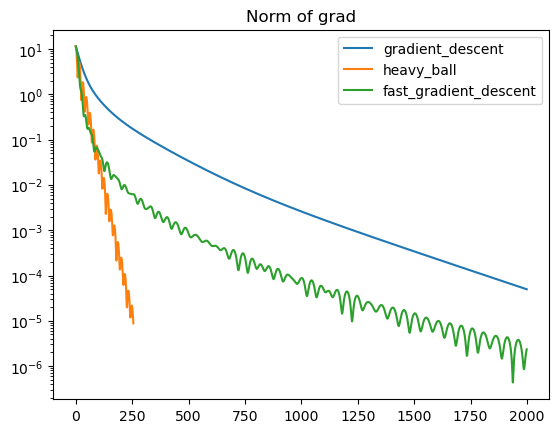

In [32]:
plt.title('Norm of grad')
plt.plot([np.linalg.norm(grad(X, Y, d, A)) for A in conv_gd[:2000]], label='gradient_descent')
plt.plot([np.linalg.norm(grad(X, Y, d, A)) for A in conv_hb[:2000]], label='heavy_ball')
plt.plot([np.linalg.norm(grad(X, Y, d, A)) for A in conv_fgd[:2000]], label='fast_gradient_descent')
plt.yscale("log")
plt.legend()
plt.show()

В целом все сходится с теорией.  
* Градиентный спуск медленнее остальных методов и непрерывный.  
* Быстрый градиентный спуск имеет скачки в норме градиента.  
* Градиентный спуск с инерцией почему то тоже имеет скачки, возможно это не очень удачные гиперпараметры (хотя странно называть их неудачными если он сходится быстрее остальных).  

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

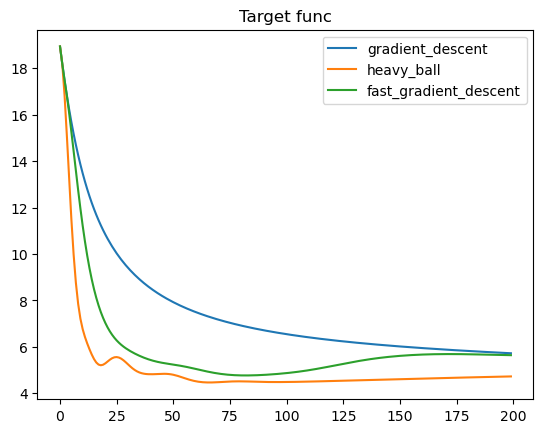

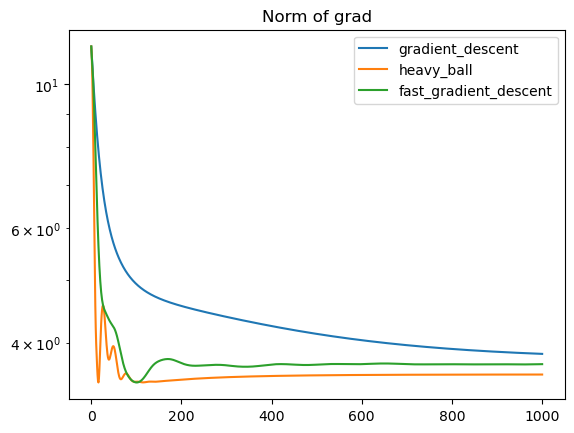

In [43]:
# TEST
A, conv_gd = gradient_descent(lambda A: grad(X_test, Y_test, d_test, A), 1e-2, np.eye(n), 1000, 1e-5)
A, conv_hb = heavy_ball(lambda A: grad(X_test, Y_test, d_test, A), 1e-2, 0.9, np.eye(n), 1000, 1e-5)
A, conv_fgd = fast_gradient_descent(lambda A: grad(X_test, Y_test, d_test, A), 1e-2, np.eye(n), 1000, 1e-5)
plt.title('Target func')
plt.plot([target_func(X, Y, d, A) for A in conv_gd[:200]], label='gradient_descent')
plt.plot([target_func(X, Y, d, A) for A in conv_hb[:200]], label='heavy_ball')
plt.plot([target_func(X, Y, d, A) for A in conv_fgd[:200]], label='fast_gradient_descent')
plt.legend()
plt.show()
plt.title('Norm of grad')
plt.plot([np.linalg.norm(grad(X, Y, d, A)) for A in conv_gd[:2000]], label='gradient_descent')
plt.plot([np.linalg.norm(grad(X, Y, d, A)) for A in conv_hb[:2000]], label='heavy_ball')
plt.plot([np.linalg.norm(grad(X, Y, d, A)) for A in conv_fgd[:2000]], label='fast_gradient_descent')
plt.yscale("log")
plt.legend()
plt.show()

С какого-то момента градиент перестает особо убывать.  
Возможно мы начинаем перескакивать через оптимум на такой выборке.  

## Задача 2 (10 pts)

- (2 pts) Покажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

- (5 pts) Докажите, что если целевая функция $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, шаг определяется с помощью наискорейшего спуска и $x^0 - x^*$ параллелен собственному вектору матрицу $Q$, то градиентный спуск сходится за один шаг. 

- Покажите, что для $f(x) = x^{\top}x$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию:
    - (1 pts) с использованием предыдущего утверждения
    - (2 pts) прямым вычислением 

## Task 1
Обозначим текущую точку $x_{i, k}$, градиент $g_k$.  
Соответсвенно 
$$\alpha = \argmin_{\alpha} f(x_{i, k} + \alpha g_k)$$ 
$$x_{k+1} = x_{i, k} + \alpha g_k$$
Пусть $<g_{k+1}, g_{k}> \neq 0$.  
Тогда $\exists \varepsilon > 0: f(x_{k+1} + \varepsilon g_{k}) < f(x_{k+1})$ 
следовательно $\alpha$ не минимум функции $f(x_{i, k} + \alpha g_k)$.  
Противоречье, следовательно $<g_{k+1}, g_{k}> = 0$

## Task 2
$$
\nabla f(x) = Qx - b\\
x^1 = x^0 - \alpha \nabla f(x^0) \quad \textit{где} \quad \alpha = \argmin_{\alpha} f(x^0 + \alpha \nabla f(x^0))
$$

$$ 
x^* = Q^{-1}b \\ 
Q(x^0 - x^*) = k(x^0 - x^*) \\
Q(x^0 - Q^{-1}b) = k(x^0 - Q^{-1}b) \\
Q x^0 - b = kx^0 - Q^{-1} b k \\
\frac{1}{k}(Q x^0 - b) = x^0 - x^* \\
x^* = x^0 - \frac{1}{k} \nabla f(x^0)
$$

Следовательно мы за один ход можем попасть в оптимум.

## Task 3
* Возьмем $Q = E, b = 0$. Тогда так как для матрицы $E$ любой вектор собственный, то по предыдущему утверждению мы за 1 ход попадем в оптимум.
* $\nabla f(x) = x$. $x^1 = x^0 - \alpha \nabla f(x^0) = x^0 - \alpha x^0$. Следовательно для при $\alpha=1$ мы за 1 ход попадем в 0 который минимумизирует данную функцию. 

## Задача 3 (15 pts)

- (5 pts) Оцените константу Липшица градиента и константу сильной выпуклости для функции

$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$

- (10 pts) Используя найденные значения сравните сходимость метода тяжёлого шарика с оптимальными параметрами и с эвристически подобранными, метода градиентного спуска с оптимальным постоянным шагом и быстрый градиентный метод. Сделайте вывод о точности оценки констант и их влиянии на скорость сходимости метода тяжёлого шарика. Векторы $x_i$ и скаляры $y_i$ генерируются кодом ниже, после чего элементы вектора $y$ необходимо преобразовать из множества $\{ 0,1\}$ в множество $\{ -1, +1\}$.

$$
f'_k(w) = w_k + \frac{C}{m} \sum_{i=1}^m \frac{- \exp(-y_i \langle x_i, w \rangle) y_i x_{i, k} }{1 + \exp(-y_i \langle x_i, w \rangle)}
$$


\begin{align*}
f''_{k, l, k \neq l} 
    &= \left( \frac{C}{m} \sum_{i=1}^m \frac{- \exp(-y_i \langle x_i, w \rangle) y_i x_{i, k} }{1 + \exp(-y_i \langle x_i, w \rangle)} \right)'_l \\
    &= \frac{C}{m} \sum_{i=1}^m \frac
        {
            \left( (\exp(-y_i \langle x_i, w \rangle) y_i x_{i, k} y_i x_{i, l}) (1 + \exp(-y_i \langle x_i, w \rangle) \right) - 
            \left( (- \exp(-y_i \langle x_i, w \rangle) y_i x_{i, k}) (- \exp(-y_i \langle x_i, w \rangle) y_i x_{i, l}) \right)
        }
        {(1 + \exp(-y_i \langle x_i, w \rangle))^2} \\
    &= \frac{C}{m} \sum_{i=1}^m \frac
        {
            \exp(-y_i \langle x_i, w \rangle) y_i x_{i, k} y_i x_{i, l} + \exp(-2 y_i \langle x_i, w \rangle) y_i^2 x_{i, k} x_{i, l}  - 
            \exp(-2y_i \langle x_i, w \rangle) y_i^2 x_{i, l} x_{i, k}
        }
        {(1 + \exp(-y_i \langle x_i, w \rangle))^2} \\
    &= \frac{C}{m} \sum_{i=1}^m \frac
        {
            \exp(-y_i \langle x_i, w \rangle) y_i^2 x_{i, k} x_{i, l}
        }
        {(1 + \exp(-y_i \langle x_i, w \rangle))^2} 
\end{align*}

\begin{align*}
f''_{k, k} 
    &= 1 + \left( \frac{C}{m} \sum_{i=1}^m \frac{- \exp(-y_i \langle x_i, w \rangle) y_i x_{i, k} }{1 + \exp(-y_i \langle x_i, w \rangle)} \right)'_k \\
    &= 1 + \frac{C}{m} \sum_{i=1}^m \frac
        {
            \exp(-y_i \langle x_i, w \rangle) y_i^2 x_{i, k} ^2
        }
        {(1 + \exp(-y_i \langle x_i, w \rangle))^2} 
\end{align*}

Тогда 
\begin{align*}
\| f''(x) \|_2 &= 
    \sum_{k \neq l} 
        \left(
            \frac{C}{m} \sum_{i=1}^m \frac
                {
                    \exp(-y_i \langle x_i, w \rangle) y_i^2 x_{i, k} x_{i, l}
                }
                {(1 + \exp(-y_i \langle x_i, w \rangle))^2}
        \right) + 
    \sum_{k=1}^n 
        \left( 
            1 + \frac{C}{m} \sum_{i=1}^m \frac
            {
                \exp(-y_i \langle x_i, w \rangle) y_i^2 x_{i, k} ^2
            }
            {(1 + \exp(-y_i \langle x_i, w \rangle))^2} 
        \right) \\
    &= n + \sum_{k, l} 
        \left(
            \frac{C}{m} \sum_{i=1}^m \frac
                {
                    \exp(-y_i \langle x_i, w \rangle) y_i^2 x_{i, k} x_{i, l}
                }
                {(1 + \exp(-y_i \langle x_i, w \rangle))^2}
        \right) \\
    &= n + \sum_{k} 
        \left(
            \frac{C}{m} \sum_{i=1}^m \frac
                {
                    \exp(-y_i \langle x_i, w \rangle) y_i^2 x_{i, k} \hat{x}_{i}
                }
                {(1 + \exp(-y_i \langle x_i, w \rangle))^2}
        \right) \quad \textit{где} \quad \hat{x}_{i} = \sum_{l=1}^n x_{i, l} \\
    &= n + 
        \frac{C}{m} \sum_{i=1}^m \frac
            {
                \exp(-y_i \langle x_i, w \rangle) y_i^2 \hat{x}_{i}^2
            }
            {(1 + \exp(-y_i \langle x_i, w \rangle))^2} \quad \textit{Заметим, что } y_i^2 = 1 \quad \frac{\exp(-y_i \langle x_i, w \rangle)}{(1 + \exp(-y_i \langle x_i, w \rangle))^2} < 1\\
    &< n + \frac{C}{m} \sum_{i=1}^{m} \hat{x}_i^2  
\end{align*}
Последняя оценка скорее всего грубоватая, наверное можем в каждой точке считать в зависимости от $w$.

По теореме $\| f''(x) \|_2 \leq L$, таким образом мы оценили $L$-гладкость функции $f$.

Рассмотрим критерий выпуклости второго порядка $f''(x) \succeq mI$  
Посчитать Гессиан функции в точке и оценить его минимальное собственное значение.  
Из него мы можем оценить константу сильной выпуклости. Более аналитического решения пока не нашел.

In [8]:
n = 300
m = 1000
import sklearn.datasets as skldata

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1
y = (2 * y - 1)

In [13]:
@njit
def grad(X, y, w, C):
    m = len(X)
    n = len(w)

    grad = np.zeros_like(w)

    for k in range(n):
        grad[k] = w[k]
        for i in range(m):
            grad[k] += C / m * (-np.exp(-y[i] * X[i] @ w) * y[i] * X[i, k]) / (1 + np.exp(-y[i]  * X[i] @ w)) 

    return grad

@njit
def gess(X, y, w, C):
    m = len(X)
    n = len(w)

    gess = np.zeros((n, n))

    for k in range(n):
        for l in range(k):
            for i in range(m):
                # y[i] ** 2 = 1  
                gess[k, l] += C / m * np.exp(-y[i] * X[i] @ w) * X[i, k] * X[i, l]
            
            gess[l, k] = gess[k, l]

    for k in range(n):
        gess[k, k] = 1
        for i in range(m):
            gess[k, k] += C / m * np.exp(-y[i] * X[i] @ w) * X[i, k] ** 2
    
    return gess


In [39]:
w0 = np.ones(n) / 1000
ge = gess(X, y, w0, C)

In [43]:
L = np.linalg.norm(ge)
mu = np.min(np.linalg.eigvals(ge)) 

In [56]:
def gradient_descent(grad_func, alpha, w0, num_iter, tol):

    w = w0.copy()
    conv = [w0.copy()]
    for _ in tqdm(range(num_iter)):
        g = grad_func(w)
        if np.linalg.norm(g) < tol:
            break
        
        w = w - alpha * g
        conv.append(w.copy())
    return w, conv

In [57]:
def heavy_ball(grad, alpha, beta, w0, num_iter, tol):
  conv = [w0.copy()]
  w = w0.copy()
  for k in tqdm(range(num_iter)):
    g = grad(w)
    if np.linalg.norm(g) < tol:
      break
    if k == 0:
      w = w - alpha * g
    else:
      w = w - alpha * g + beta * (w - conv[-2])

    conv.append(w.copy())

  return w, conv

def fast_gradient_descent(grad, alpha, w0, num_iter, tol):
  conv = [w0.copy()]
  w = w0.copy()
  v = w0.copy()
  theta = 1.
  for k in tqdm(range(num_iter)):
    y = (1 - theta) * w + theta * v
    g = grad(y)
    w = y - alpha * g
    v = conv[-1] + 1 / theta * (A - conv[-1])
    conv.append(w.copy())
    theta = 2 / (k+2)
    
  return w, conv

In [58]:
def target_func(X, y, w, C):
    ans = w @ w / 2
    ans += (np.log(np.exp((X @ w0) * y) + 1) * C / m).sum()
    return ans
    

In [59]:
w, conv_gd = gradient_descent(lambda w: grad(X, y, w, C), 1 / L, w0, 1_000, 1e-5)
w, conv_hb = heavy_ball(lambda w: grad(X, y, w, C), 1 / L, 0.9, w0, 1_000, 1e-5)
w, conv_fgd = fast_gradient_descent(lambda w: grad(X, y, w, C), 1 / L, w0, 1_000, 1e-5)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plt.title('Target func')
plt.plot([target_func(X, y, w, C) for w in conv_gd[:200]], label='gradient_descent')
plt.plot([target_func(X, y, w, C) for w in conv_hb[:200]], label='heavy_ball')
plt.plot([target_func(X, y, w, C) for w in conv_fgd[:200]], label='fast_gradient_descent')
plt.legend()
plt.show()

In [ ]:
plt.title('Norm of grad')
plt.plot([np.linalg.norm(grad(X, y, w, C)) for w in conv_gd[:2000]], label='gradient_descent')
plt.plot([np.linalg.norm(grad(X, y, w, C)) for w in conv_hb[:2000]], label='heavy_ball')
plt.plot([np.linalg.norm(grad(X, y, w, C)) for w in conv_fgd[:2000]], label='fast_gradient_descent')
plt.yscale("log")
plt.legend()
plt.show()